In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import numpy as np

In [3]:
class Grid():
    
    def __init__(self, dx, Lx):        
            # nbr of cells
        self.nx = int(Lx/dx)
        self.dx = dx
        self.Lx = Lx

        self.nghost_cells = 1

        self.p_psi = 1                     # primal physical start index
        self.d_psi = 1                     # dual ...
        self.d_pei = self.nghost_cells + self.nx-1   # dual physical end index
        self.p_pei = self.nghost_cells + self.nx     # primal ....

        # nbr of primal (p) and dual (d) nodes
        self.nxp = self.nx + 1 + 2*self.nghost_cells  
        self.nxd = self.nx + 2*self.nghost_cells

        self.xd = self.dx * np.arange(self.nxd) - self.dx*0.5
        self.xp = self.dx * np.arange(self.nxp) - self.dx
        
        

    def deriv1_d2p(self,f):
        return (f[self.d_psi:self.d_pei+2] - f[self.d_psi-1:self.d_pei+1])/self.dx

    def deriv1_p2d(self,f):
        return (f[self.p_psi+1:self.p_pei+1] - f[self.p_psi:self.p_pei])/self.dx

    def fill_pghosts_periodic(self,f):
        f[self.p_psi-1] = f[self.p_pei-1]
        f[self.p_pei+1] = f[self.p_psi+1]

    def fill_dghosts_periodic(self,f):
        f[self.d_psi-1] = f[self.d_pei]
        f[self.d_pei+1] = f[self.d_psi]

    def p_domain(self,):
        return np.arange(self.p_psi, self.p_pei+1)

    def d_domain(self,):
        return np.arange(self.d_psi, self.d_pei+1)

    def p2d(self,f):
        return 0.5*(f[self.p_psi:self.p_pei+2]+f[self.p_psi-1:self.p_pei+1])

    def d2p(self,f):
        d = np.zeros(self.nxp)
        d[self.p_domain()] =   0.5*(f[self.d_psi:self.d_pei+2]+f[self.d_psi-1:self.d_pei+1])
        self.fill_pghosts_periodic(d)
        return d

    def is_periodic_p(self,f):
        return (f[self.p_pei] == f[self.p_psi]) and (f[self.p_pei-1] == f[self.p_psi-1]) and (f[self.p_pei+1] == f[self.p_psi+1])

In [12]:
def conserv(u, phi, dphi, num_flux, boundary_condition, grid,**kwargs):
    f = num_flux(u, phi, dphi, boundary_condition, grid, **kwargs)
    divF = grid.deriv1_d2p(f)
    u[grid.p_domain()] += - divF *kwargs["dt"]
    if boundary_condition == "periodic":
        grid.fill_pghosts_periodic(u)
    else:
        raise RuntimeError("unsupported boundary condition")

## Initial condition

In [13]:
def initialize(init, grid):
    u = np.zeros(grid.nxp)
    if init == "sine":
        u[:] = np.sin(grid.xp*2*np.pi/grid.Lx)*0.2
    elif init=="square":
        u[:] = 0.5*(1+np.tanh((grid.xp-grid.Lx*0.4))) - 0.5*(1+np.tanh((grid.xp-grid.Lx*0.6)))
    
    elif init=="case1":
        where1 = np.where( (grid.xp>0.5) & ( grid.xp<1.5))[0]
        u[where1] = 1
    
    else:
        raise RuntimeError("unsupported initial condition")
        
    
    u0 = np.copy(u)
    return u, u0

## Burger's equation

$\partial_t u  + u \partial_x u = 0$

which also writes:

$\partial_t u  + \frac{1}{2} \partial_x u^2 = 0$

so $\partial_t u  + \partial_x f = 0$ with $f = \frac{1}{2}u^2$

In [14]:
def burger_flux(u):
    return 0.5*u*u
def dburger_flux(u):
    return u

## advection equation

$\partial_t u + a\partial_x u = 0$

In [15]:
def adv_flux(u, a=1):
    return a*u
def dadv_flux(u,a=1):
    return a

## Methods

### Lax Friedrichs

In [16]:
#example with nx=5 cells + 1 ghost cell on each side
#d_psi           1
#p_psi        1    
#d_pei                                   5
#p_pei                                      6
#border       |                             |
# prim  0     1     2     3     4     5     6
# dual     0     1     2     3     4     5     6
# tot   +  o  +  o  +  o  +  o  +  o  +  o  +  o  +

def LaxFriedrichs(u, phi, dphi, boundary_condition, grid, **kwargs):
    fr = np.zeros(grid.nxd)
    phi_d = grid.p2d(phi(u))
    dt = kwargs["dt"]
    fr[grid.d_psi:grid.d_pei+2]   = phi_d[grid.d_psi:grid.d_pei+2]   - grid.dx/dt*0.5*(u[grid.p_psi+1:grid.p_pei+2]-u[grid.p_psi:grid.p_pei+1])
    if boundary_condition == "periodic":
        fr[grid.d_psi-1] = fr[grid.d_pei]
    return fr#, fl

### WENO 3

- compute $\hat{f}^\pm(u_i)$ 
    - Lax-Friedrichs flux needs to compute $\frac{1}{2}\left(f(u_i) \pm \alpha u_i\right)$ with $\alpha = max |\partial_u f|$, the max is taken within the stencil (local) or globally on the grid
- compute $\hat{f}^+_{i+1/2} = w_1q_1 + w_2q_2$ 
    - $q_1 = \frac{1}{2}f^+(u_i) + \frac{1}{2}f^+(u_i)$
    - $q_2 = \frac{-1}{2}f^+(u_{i-1}) + \frac{3}{2}f^+(u_i)$
    - $w_k = \frac{\alpha_k}{\alpha_1 + \alpha_2}$
    - $\alpha_k = \frac{c_k}{\beta_k + \epsilon}$
    - $c_k = (1/3,2/3)$
    - $\epsilon=1e-40$
    - Liu2017 : 
        - $\beta_0 = \frac{1}{4}\left(|f_{i+1} - f_i| - |4f_i - 3 f_{i-1} - f_{i+1}|\right)^2$
        - $\beta_1 = \frac{1}{4}\left(|f_{i+1} - f_i| - |3f_{i+1} - f_{i-1} - 4f_{i}|\right)^2$
    - JS : 
        - $\beta_1 = (f_{i+1} - f{i})^2$
        - $\beta_1 = (f_{i} - f{i-1})^2$

In [17]:
def lf(u, phi, dphi):
    fi = phi(u)
    dfi = dphi(u)
    alpha = np.max(np.abs(dfi))
    return 0.5*fi + alpha*u, 0.5*fi - alpha*u

def weno(u, phi, dphi, boundary_condition, grid, **kwargs):
    
    estimator=kwargs.get("estimator", "JS")
    eps=1e-40
    
    fp,fm  = lf(u, phi, dphi)
    f_r   = np.zeros(grid.nxd) 
    
    def weno_(u, f, estimator):
        f_ip1 = f[grid.p_psi+1:grid.p_pei+2]
        f_im1 = f[grid.p_psi-1:grid.p_pei]
        f_i   = f[grid.p_domain()] 
        
        if estimator=="Liu17":
            # liu2017  : https://onlinelibrary.wiley.com/doi/epdf/10.1002/fld.4480
            beta2 = 0.25*(np.abs(f_ip1 - f_im1) - np.abs(4*f_i - 3*f_im1 - f_ip1))**2
            beta1 = 0.25*(np.abs(f_ip1 - f_im1) - np.abs(3*f_ip1 + f_im1 - 4*f_i))**2
        
        elif estimator =="JS":
        # weno-JS 96
            beta1 = (f_ip1 - f_i)**2
            beta2 = (f_i   - f_im1)**2
        else:
            raise ValueError(f"unsupported estimator: {estimator}")
            
        c1,c2 = 1/3,2/3

        alpha1 = c1/(beta1 + eps)**2
        alpha2 = c2/(beta2 + eps)**2
        
        w1 = alpha1/(alpha1 + alpha2)
        w2 = alpha2/(alpha1 + alpha2)

        q1 = 0.5*f_i + 0.5*f_ip1
        q2 = -0.5*f_im1 + 1.5*f_i
        
        fr = w1*q1 + w2*q2
        return fr
    
    # f^\pm_{i+1/2}
    fr_p = weno_(u,fp, estimator)
    fr_m = weno_(u,fm, estimator)
    
    if boundary_condition=="periodic":
        f_r[grid.d_psi:grid.d_pei+2] = fr_p + fr_m
        f_r[grid.d_psi-1] = f_r[grid.d_pei]
    return f_r

In [18]:
def run(dt, T, dx, Lx, init, equation):

    nt = int(T/dt)+1
    times = np.arange(nt)*dt

    grid = Grid(dx, Lx)

    udiag = {}
    udiag["LF"]        = np.zeros((grid.nxp,nt))
    udiag["WENO3-JS"]  = np.zeros((grid.nxp,nt))
    udiag["WENO3-Liu"] = np.zeros((grid.nxp,nt))

    u = {}
    u["LF"], u0        = initialize(init, grid)
    u["WENO3-JS"], u0  = initialize(init, grid)
    u["WENO3-Liu"], u0 = initialize(init, grid)

    if equation=="advection":
        flux  = adv_flux
        dflux = dadv_flux
    elif equation=="burger":
        flux  = burger_flux
        dflux = dburger_flux 
    
    for it,t in enumerate(times):

        conserv(u["LF"]       , flux, dflux, LaxFriedrichs, "periodic", grid, dt=dt)
        conserv(u["WENO3-JS"] , flux, dflux, weno         , "periodic", grid, dt=dt, estimator="JS")
        conserv(u["WENO3-Liu"], flux, dflux, weno         , "periodic", grid, dt=dt, estimator="Liu17")

        udiag["LF"][:,it]        = u["LF"]      
        udiag["WENO3-JS"][:,it]  = u["WENO3-JS"]
        udiag["WENO3-Liu"][:,it] = u["WENO3-Liu"]
        
    return grid, u0, udiag, times
    

In [19]:
grid, u0, udiag, times = run(0.1, 2000, 0.2, 200, "square",  "advection")

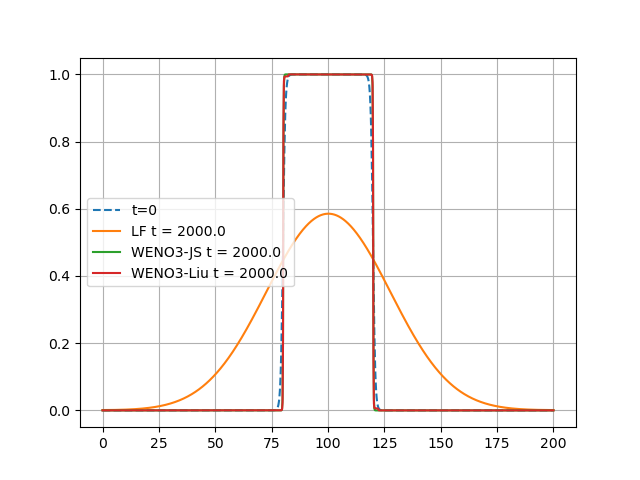

In [20]:
fig,ax = plt.subplots()
ax.plot(grid.xp,u0,ls="--", label="t=0")
for itdiag in [-1]:
    for method, u in udiag.items():
        ax.plot(grid.xp, u[:,itdiag], label="{} t = {:4.1f}".format(method,times[itdiag]))
ax.grid()
ax.legend()

In [23]:
grid, u0, udiag, times = run(0.005, 8, 0.01, 2, "case1",  "advection")

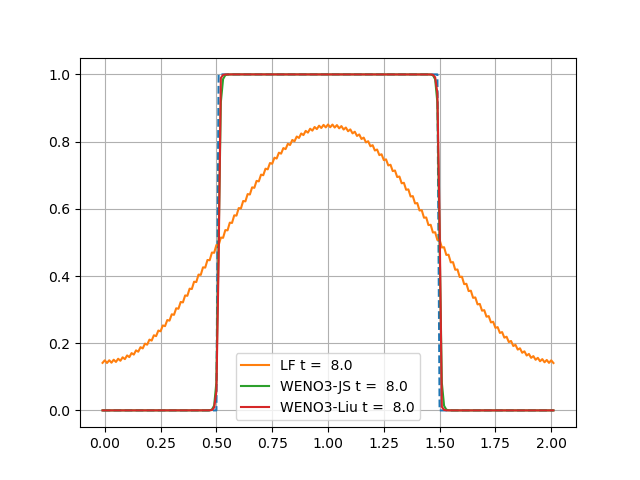

In [29]:
fig,ax = plt.subplots()
ax.plot(grid.xp,u0,ls="--")
for itdiag in [-1]:
    for method, u in udiag.items():
        ax.plot(grid.xp, u[:,itdiag], label="{} t = {:4.1f}".format(method,times[itdiag]))
ax.grid()
ax.legend()

In [30]:
grid, u0, udiag, times = run(0.1, 2000, 0.2, 200, "sine",  "advection")

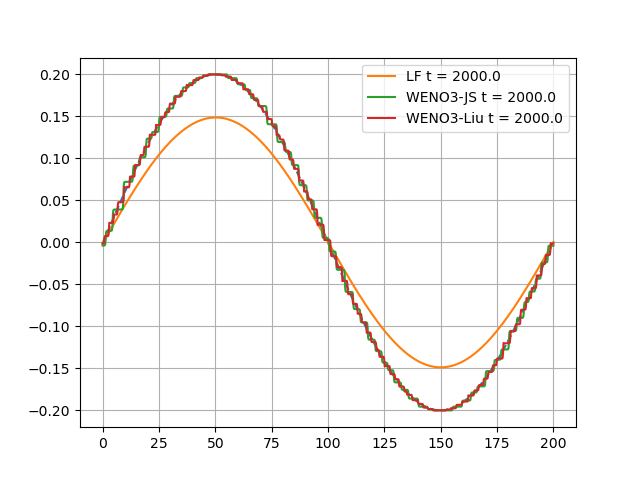

In [31]:

fig,ax = plt.subplots()
ax.plot(grid.xp,u0,ls="--")
for itdiag in [-1]:
    for method, u in udiag.items():
        ax.plot(grid.xp, u[:,itdiag], label="{} t = {:4.1f}".format(method,times[itdiag]))
ax.grid()
ax.legend()

In [ ]:
grid, u0, udiag, times = run(0.002, 500, 0.01, 200, "sine", "burger")

In [ ]:

fig,ax = plt.subplots()
ax.plot(grid.xp,u0,ls="--")
for itdiag in [4000]:
    for method, u in udiag.items():
        ax.plot(grid.xp, u[:,itdiag], label="{} t = {:4.1f}".format(method,times[itdiag]))
ax.grid()
ax.legend()

In [177]:
grid, u0, udiag, times = run(0.1, 100, 0.2, 200, "square", "burger")

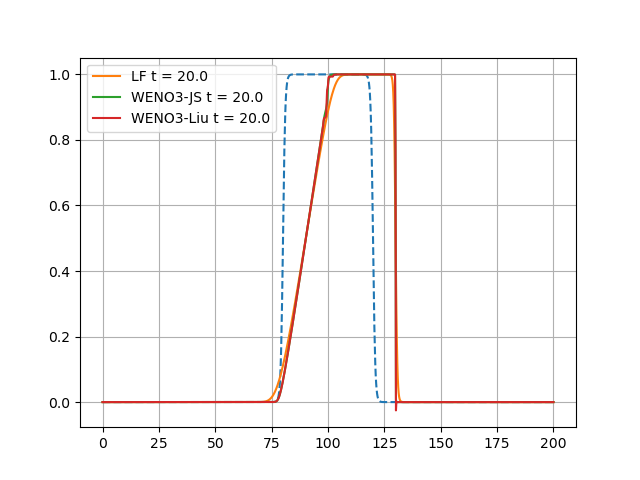

In [179]:

fig,ax = plt.subplots()
ax.plot(grid.xp,u0,ls="--")
for itdiag in [200]:
    for method, u in udiag.items():
        ax.plot(grid.xp, u[:,itdiag], label="{} t = {:4.1f}".format(method,times[itdiag]))
ax.grid()
ax.legend()